In [7]:
import duckdb
import pandas as pd

conn = duckdb.connect()

# Your query
result = conn.execute("""
    SELECT 
        t.timestamp,
        c.pool_old,
        c.protocol_slug,
        c.chain,
        c.symbol,
        c.pool_meta,
        c.tvl_usd,
        t.tvlUsd,
        t.apy,
        t.apyBase,
        t.apyReward,
        t.pool_id
    FROM read_parquet('output/tvl_data.parquet') t
    LEFT JOIN read_parquet('output/current_state.parquet') c
    ON t.pool_id = c.pool
""").fetchdf()  # Returns pandas DataFrame

# Easy data quality checks
print("Shape:", result.shape)
print("\nDuplicates:", result.duplicated().sum())
print("\nNull values:")
print("\n")
print(result.isnull().sum())
result.head()


Shape: (455337, 12)

Duplicates: 0

Null values:


timestamp             0
pool_old           2931
protocol_slug      2931
chain              2931
symbol             2931
pool_meta        401183
tvl_usd            2931
tvlUsd                0
apy                   0
apyBase            9805
apyReward         38986
pool_id               0
dtype: int64


,timestamp,pool_old,protocol_slug,chain,symbol,pool_meta,tvl_usd,tvlUsd,apy,apyBase,apyReward,pool_id
0,2025-07-10T23:04:57.191Z,0x6446021f4e396da3df4235c62537431372195d38,aerodrome-slipstream,Base,WETH-OETHB,CL1 - 0.04%,815672271.0,564026367.0,0.05221,0.00048,0.05173,bc33d1ea-f566-40eb-b0a8-8d8dcf425f18
1,2025-07-11T23:07:02.346Z,0x6446021f4e396da3df4235c62537431372195d38,aerodrome-slipstream,Base,WETH-OETHB,CL1 - 0.04%,815672271.0,557604594.0,0.05253,0.00080,0.05174,bc33d1ea-f566-40eb-b0a8-8d8dcf425f18
2,2025-07-12T23:05:21.459Z,0x6446021f4e396da3df4235c62537431372195d38,aerodrome-slipstream,Base,WETH-OETHB,CL1 - 0.04%,815672271.0,556792038.0,0.05063,0.00021,0.05043,bc33d1ea-f566-40eb-b0a8-8d8dcf425f18
3,2025-07-13T23:05:55.908Z,0x6446021f4e396da3df4235c62537431372195d38,aerodrome-slipstream,Base,WETH-OETHB,CL1 - 0.04%,815672271.0,562508846.0,0.05341,0.00018,0.05322,bc33d1ea-f566-40eb-b0a8-8d8dcf425f18
4,2025-07-14T18:06:23.414Z,0x6446021f4e396da3df4235c62537431372195d38,aerodrome-slipstream,Base,WETH-OETHB,CL1 - 0.04%,815672271.0,570298554.0,0.05319,0.00024,0.05295,bc33d1ea-f566-40eb-b0a8-8d8dcf425f18


<Axes: >

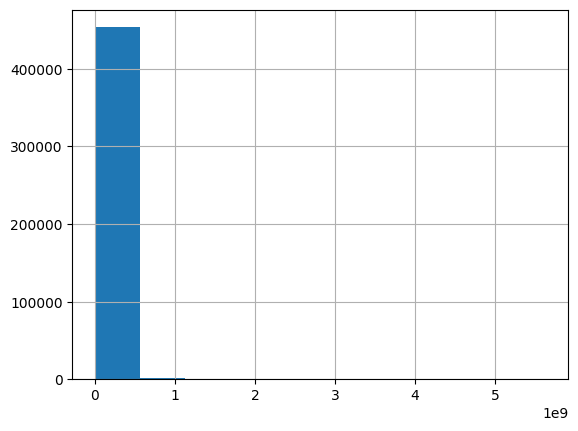

In [8]:
   import matplotlib.pyplot as plt
   result['tvlUsd'].hist()

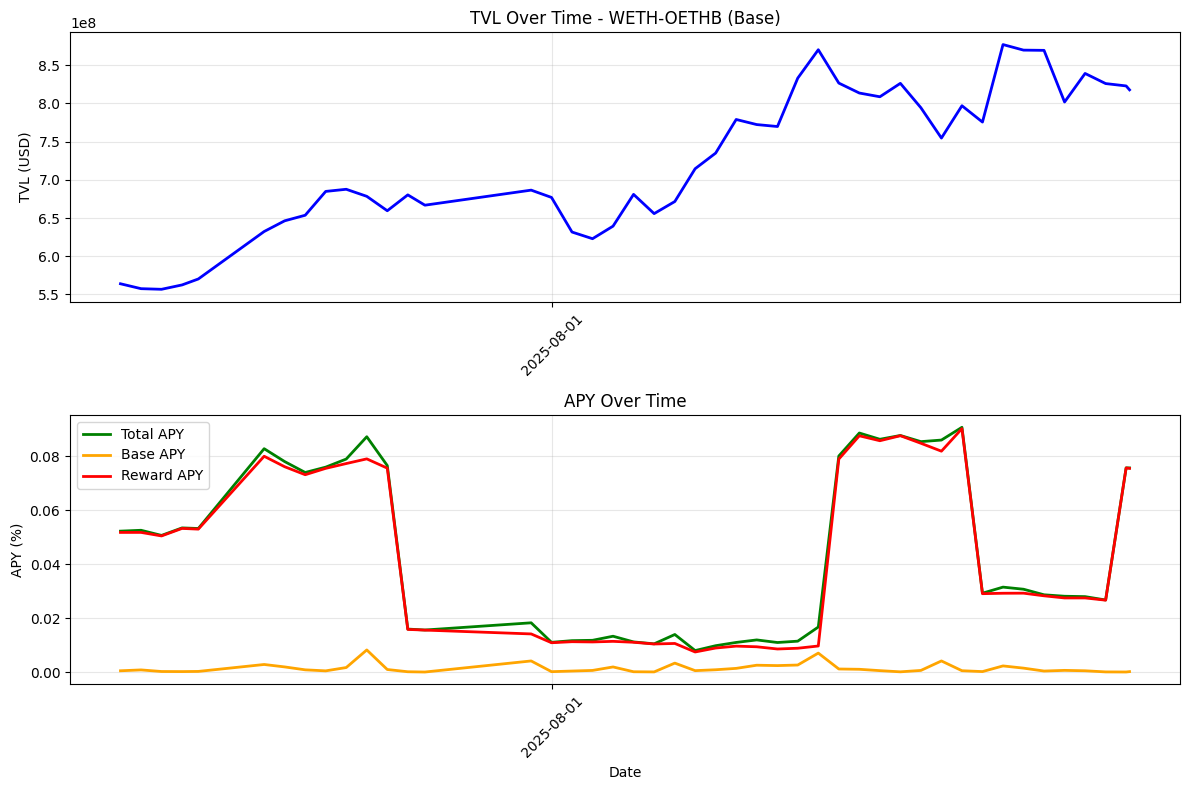

Pool: 0x6446021f4e396da3df4235c62537431372195d38
Protocol: aerodrome-slipstream
Chain: Base
Symbol: WETH-OETHB
Date Range: 2025-07-10 23:04:57.191000+00:00 to 2025-08-29 03:05:54.955000+00:00
TVL Range: $556,792,038 to $877,127,952
APY Range: 0.01% to 0.09%


In [13]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 

# connect to duckdb
conn = duckdb.connect()

# query for time series, join, filtered on specific pool
query = """
    SELECT
        t.timestamp
        , c.pool_old
        , c.protocol_slug
        , c.chain 
        , c.symbol
        , t.tvlUsd
        , t.apy 
        , t.apyBase
        , t.apyReward
    FROM read_parquet('output/tvl_data.parquet') t
    LEFT JOIN read_parquet('output/current_state.parquet') c 
        ON t.pool_id = c.pool 
    WHERE c.pool_old = '0x6446021f4e396da3df4235c62537431372195d38'
    ORDER BY t.timestamp
"""

# execute and save results
result = conn.execute(query).fetchdf()

# convert timestamp to datetime 
result['timestamp'] = pd.to_datetime(result['timestamp'])

# create plot
plt.figure(figsize=(12,8))

# plot TVL overtime
plt.subplot(2,1,1)
plt.plot(result['timestamp'], result['tvlUsd'], linewidth=2, color='blue')
plt.title(f'TVL Over Time - {result["symbol"].iloc[0]} ({result["chain"].iloc[0]})')
plt.ylabel('TVL (USD)')
plt.grid(True, alpha=0.3) 

# format x-axis
# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Plot APY over time
plt.subplot(2, 1, 2)
plt.plot(result['timestamp'], result['apy'], linewidth=2, color='green', label='Total APY')
plt.plot(result['timestamp'], result['apyBase'], linewidth=2, color='orange', label='Base APY')
plt.plot(result['timestamp'], result['apyReward'], linewidth=2, color='red', label='Reward APY')
plt.title('APY Over Time')
plt.ylabel('APY (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary stats
print(f"Pool: {result['pool_old'].iloc[0]}")
print(f"Protocol: {result['protocol_slug'].iloc[0]}")
print(f"Chain: {result['chain'].iloc[0]}")
print(f"Symbol: {result['symbol'].iloc[0]}")
print(f"Date Range: {result['timestamp'].min()} to {result['timestamp'].max()}")
print(f"TVL Range: ${result['tvlUsd'].min():,.0f} to ${result['tvlUsd'].max():,.0f}")
print(f"APY Range: {result['apy'].min():.2f}% to {result['apy'].max():.2f}%")

In [18]:
import duckdb
import pandas as pd
import numpy as np

# Connect to DuckDB
conn = duckdb.connect()

def data_quality_report(dataset_name, query):
    """Generate comprehensive data quality report"""
    print(f"\n{'='*60}")
    print(f"📊 DATA QUALITY REPORT: {dataset_name}")
    print(f"{'='*60}")
    
    # Load data
    df = conn.execute(query).fetchdf()
    
    # Basic info
    print(f"📈 Basic Information:")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {len(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values
    print(f"\n❌ Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    for col, count in missing.items():
        if count > 0:
            print(f"   {col}: {count:,} ({missing_pct[col]:.2f}%)")
        else:
            print(f"   {col}: 0 (0.00%)")
    
    # Duplicates - handle list columns
    print(f"\n🔄 Duplicates:")
    try:
        # Try to check duplicates on all columns
        total_duplicates = df.duplicated().sum()
        print(f"   Total duplicate rows: {total_duplicates:,}")
    except TypeError:
        # If there are list columns, check duplicates on non-list columns only
        print("   Note: Skipping duplicate check due to list columns")
        # Check for duplicates on key columns only
        key_columns = []
        for col in df.columns:
            if df[col].dtype != 'object' or not any(isinstance(x, list) for x in df[col].dropna().head(10)):
                key_columns.append(col)
        
        if key_columns:
            print(f"   Checking duplicates on key columns: {key_columns}")
            total_duplicates = df[key_columns].duplicated().sum()
            print(f"   Duplicate rows (key columns only): {total_duplicates:,}")
    
    # Data types
    print(f"\n📋 Data Types:")
    for col, dtype in df.dtypes.items():
        print(f"   {col}: {dtype}")
    
    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n📊 Numeric Columns Summary:")
        for col in numeric_cols:
            if not df[col].isnull().all():
                print(f"   {col}:")
                print(f"      Min: {df[col].min():,.2f}")
                print(f"      Max: {df[col].max():,.2f}")
                print(f"      Mean: {df[col].mean():,.2f}")
                print(f"      Median: {df[col].median():,.2f}")
                print(f"      Std: {df[col].std():,.2f}")
    
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"\n🏷️ Categorical Columns:")
        for col in categorical_cols:
            # Check if column contains lists
            sample_values = df[col].dropna().head(10)
            has_lists = any(isinstance(x, list) for x in sample_values)
            
            if has_lists:
                print(f"   {col}: Contains lists (skipping unique count)")
            else:
                unique_count = df[col].nunique()
                print(f"   {col}: {unique_count:,} unique values")
                if unique_count <= 10:
                    print(f"      Values: {list(df[col].unique())}")
    
    return df

# 1. TVL Data Quality Report
tvl_df = data_quality_report(
    "TVL Data", 
    "SELECT * FROM read_parquet('output/tvl_data.parquet')"
)

# 2. Current State Data Quality Report
current_df = data_quality_report(
    "Current State Data", 
    "SELECT * FROM read_parquet('output/current_state.parquet')"
)



# 3. Join Quality Report
print(f"\n{'='*60}")
print(f"🔗 JOIN QUALITY REPORT")
print(f"{'='*60}")

# Check join integrity
join_query = """
    SELECT 
        t.pool_id,
        c.pool as current_pool,
        COUNT(*) as record_count
    FROM read_parquet('output/tvl_data.parquet') t
    LEFT JOIN read_parquet('output/current_state.parquet') c
    ON t.pool_id = c.pool
    GROUP BY t.pool_id, c.pool
"""

join_df = conn.execute(join_query).fetchdf()

print(f"📊 Join Statistics:")
print(f"   Total TVL records: {len(tvl_df):,}")
print(f"   Total current state records: {len(current_df):,}")
print(f"   Unique pools in TVL: {tvl_df['pool_id'].nunique():,}")
print(f"   Unique pools in current state: {current_df['pool'].nunique():,}")

# Check for orphaned records
orphaned_tvl = conn.execute("""
    SELECT COUNT(*) as orphaned_count
    FROM read_parquet('output/tvl_data.parquet') t
    LEFT JOIN read_parquet('output/current_state.parquet') c
    ON t.pool_id = c.pool
    WHERE c.pool IS NULL
""").fetchone()[0]

print(f"   Orphaned TVL records (no current state): {orphaned_tvl:,}")
print(f"   Join success rate: {((len(tvl_df) - orphaned_tvl) / len(tvl_df)) * 100:.2f}%")

# 4. Specific Data Quality Checks
print(f"\n�� SPECIFIC DATA QUALITY CHECKS:")

# Check for negative TVL values
negative_tvl = conn.execute("""
    SELECT COUNT(*) as negative_count
    FROM read_parquet('output/tvl_data.parquet')
    WHERE tvlUsd < 0
""").fetchone()[0]
print(f"   Negative TVL values: {negative_tvl:,}")

# Check for extreme APY values
extreme_apy = conn.execute("""
    SELECT COUNT(*) as extreme_count
    FROM read_parquet('output/tvl_data.parquet')
    WHERE apy > 1000 OR apy < -100
""").fetchone()[0]
print(f"   Extreme APY values (>1000% or <-100%): {extreme_apy:,}")

# Check timestamp consistency
timestamp_issues = conn.execute("""
    SELECT COUNT(*) as issue_count
    FROM read_parquet('output/tvl_data.parquet')
    WHERE timestamp IS NULL OR timestamp = ''
""").fetchone()[0]
print(f"   Invalid timestamps: {timestamp_issues:,}")

# Check for duplicate pool_ids in current state
duplicate_pools = conn.execute("""
    SELECT pool, COUNT(*) as count
    FROM read_parquet('output/current_state.parquet')
    GROUP BY pool
    HAVING COUNT(*) > 1
""").fetchall()
print(f"   Duplicate pools in current state: {len(duplicate_pools)}")

if len(duplicate_pools) > 0:
    print("   Duplicate pool details:")
    for pool, count in duplicate_pools:
        print(f"      {pool}: {count} records")

# 5. Sample Data Preview
print(f"\n👀 SAMPLE DATA PREVIEW:")
print(f"\nTVL Data (first 3 rows):")
print(tvl_df.head(3).to_string())

print(f"\nCurrent State Data (first 3 rows):")
print(current_df.head(3).to_string())

conn.close()


📊 DATA QUALITY REPORT: TVL Data
📈 Basic Information:
   Rows: 455,337
   Columns: 6
   Memory usage: 89.45 MB

❌ Missing Values:
   timestamp: 0 (0.00%)
   tvlUsd: 0 (0.00%)
   apy: 0 (0.00%)
   apyBase: 9,805 (2.15%)
   apyReward: 38,986 (8.56%)
   pool_id: 0 (0.00%)

🔄 Duplicates:
   Total duplicate rows: 0

📋 Data Types:
   timestamp: object
   tvlUsd: float64
   apy: float64
   apyBase: float64
   apyReward: float64
   pool_id: object

📊 Numeric Columns Summary:
   tvlUsd:
      Min: 1,000.00
      Max: 5,636,336,220.00
      Mean: 12,253,254.51
      Median: 549,345.00
      Std: 109,218,481.71
   apy:
      Min: 0.00
      Max: 339,748.57
      Mean: 22.55
      Median: 2.25
      Std: 964.97
   apyBase:
      Min: 0.00
      Max: 339,748.57
      Mean: 7.45
      Median: 0.50
      Std: 800.58
   apyReward:
      Min: 0.00
      Max: 240,331.09
      Mean: 16.55
      Median: 0.01
      Std: 575.58

🏷️ Categorical Columns:
   timestamp: 5,338 unique values
   pool_id: 1,124 uni